## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

### 請比較使用不同層數以及不同 Dropout rate 對訓練的效果

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.2, 0.3]
NN_Num = [[512, 256, 128], [512, 256, 128, 64], [512, 256, 128, 64, 32]]

In [7]:
results = {}

for nn, dp in itertools.product(NN_Num, Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Layers = %i, Dropout = %.1f" % (len(nn), dp))
    model = build_mlp(input_shape=x_train.shape[1:], num_neurons=nn, drp_ratio=dp)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "layer-%s-dropout-%s" % (str(len(nn)), str(dp))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Layers = 3, Dropout = 0.1
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)

50000/50000 [==============================] - 4s 73us/sample - loss: 1.1417 - accuracy: 0.5947 - val_loss: 1.2819 - val_accuracy: 0.5443
Epoch 46/50
50000/50000 [==============================] - 4s 79us/sample - loss: 1.1298 - accuracy: 0.5953 - val_loss: 1.2825 - val_accuracy: 0.5454
Epoch 47/50
50000/50000 [==============================] - 4s 80us/sample - loss: 1.1246 - accuracy: 0.5984 - val_loss: 1.3099 - val_accuracy: 0.5351
Epoch 48/50
50000/50000 [==============================] - 4s 77us/sample - loss: 1.1151 - accuracy: 0.6023 - val_loss: 1.3031 - val_accuracy: 0.5383
Epoch 49/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.1100 - accuracy: 0.6030 - val_loss: 1.2986 - val_accuracy: 0.5491
Epoch 50/50
50000/50000 [==============================] - 4s 76us/sample - loss: 1.0974 - accuracy: 0.6099 - val_loss: 1.2832 - val_accuracy: 0.5496
Experiment with Layers = 3, Dropout = 0.2
Model: "model"
_______________________________________________________

Epoch 40/50
50000/50000 [==============================] - 4s 84us/sample - loss: 1.3021 - accuracy: 0.5344 - val_loss: 1.3207 - val_accuracy: 0.5322
Epoch 41/50
50000/50000 [==============================] - 4s 81us/sample - loss: 1.2906 - accuracy: 0.5376 - val_loss: 1.3221 - val_accuracy: 0.5340
Epoch 42/50
50000/50000 [==============================] - 4s 82us/sample - loss: 1.2859 - accuracy: 0.5416 - val_loss: 1.3202 - val_accuracy: 0.5333
Epoch 43/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.2792 - accuracy: 0.5405 - val_loss: 1.3130 - val_accuracy: 0.5315
Epoch 44/50
50000/50000 [==============================] - 4s 80us/sample - loss: 1.2701 - accuracy: 0.5431 - val_loss: 1.3055 - val_accuracy: 0.5406
Epoch 45/50
50000/50000 [==============================] - 4s 84us/sample - loss: 1.2677 - accuracy: 0.5448 - val_loss: 1.3179 - val_accuracy: 0.5302
Epoch 46/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.2582 - accuracy:

50000/50000 [==============================] - 4s 76us/sample - loss: 1.4391 - accuracy: 0.4871 - val_loss: 1.3808 - val_accuracy: 0.5079
Epoch 35/50
50000/50000 [==============================] - 4s 76us/sample - loss: 1.4328 - accuracy: 0.4869 - val_loss: 1.3879 - val_accuracy: 0.5070
Epoch 36/50
50000/50000 [==============================] - 4s 77us/sample - loss: 1.4241 - accuracy: 0.4910 - val_loss: 1.3875 - val_accuracy: 0.5012
Epoch 37/50
50000/50000 [==============================] - 4s 79us/sample - loss: 1.4153 - accuracy: 0.4937 - val_loss: 1.3669 - val_accuracy: 0.5121
Epoch 38/50
50000/50000 [==============================] - 4s 83us/sample - loss: 1.4146 - accuracy: 0.4954 - val_loss: 1.3714 - val_accuracy: 0.5062
Epoch 39/50
50000/50000 [==============================] - 4s 82us/sample - loss: 1.4061 - accuracy: 0.4954 - val_loss: 1.3607 - val_accuracy: 0.5123
Epoch 40/50
50000/50000 [==============================] - 4s 79us/sample - loss: 1.4019 - accuracy: 0.5008 - va

Epoch 27/50
50000/50000 [==============================] - 4s 86us/sample - loss: 1.3331 - accuracy: 0.5227 - val_loss: 1.3679 - val_accuracy: 0.5059
Epoch 28/50
50000/50000 [==============================] - 4s 81us/sample - loss: 1.3234 - accuracy: 0.5273 - val_loss: 1.3456 - val_accuracy: 0.5195
Epoch 29/50
50000/50000 [==============================] - 4s 83us/sample - loss: 1.3099 - accuracy: 0.5285 - val_loss: 1.3486 - val_accuracy: 0.5179
Epoch 30/50
50000/50000 [==============================] - 4s 83us/sample - loss: 1.3015 - accuracy: 0.5359 - val_loss: 1.3491 - val_accuracy: 0.5138
Epoch 31/50
50000/50000 [==============================] - 4s 83us/sample - loss: 1.2915 - accuracy: 0.5369 - val_loss: 1.3506 - val_accuracy: 0.5195
Epoch 32/50
50000/50000 [==============================] - 4s 83us/sample - loss: 1.2752 - accuracy: 0.5449 - val_loss: 1.3409 - val_accuracy: 0.5234
Epoch 33/50
50000/50000 [==============================] - 4s 86us/sample - loss: 1.2710 - accuracy:

Epoch 20/50
50000/50000 [==============================] - 4s 85us/sample - loss: 1.5443 - accuracy: 0.4503 - val_loss: 1.4557 - val_accuracy: 0.4859
Epoch 21/50
50000/50000 [==============================] - 4s 82us/sample - loss: 1.5301 - accuracy: 0.4554 - val_loss: 1.4567 - val_accuracy: 0.4843
Epoch 22/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.5206 - accuracy: 0.4613 - val_loss: 1.4388 - val_accuracy: 0.4898
Epoch 23/50
50000/50000 [==============================] - 4s 84us/sample - loss: 1.5059 - accuracy: 0.4635 - val_loss: 1.4359 - val_accuracy: 0.4859
Epoch 24/50
50000/50000 [==============================] - 4s 82us/sample - loss: 1.4960 - accuracy: 0.4654 - val_loss: 1.4169 - val_accuracy: 0.4956
Epoch 25/50
50000/50000 [==============================] - 4s 80us/sample - loss: 1.4905 - accuracy: 0.4707 - val_loss: 1.4216 - val_accuracy: 0.4949
Epoch 26/50
50000/50000 [==============================] - 4s 77us/sample - loss: 1.4774 - accuracy:

Epoch 13/50
50000/50000 [==============================] - 4s 78us/sample - loss: 1.7711 - accuracy: 0.3608 - val_loss: 1.6442 - val_accuracy: 0.4215
Epoch 14/50
50000/50000 [==============================] - 4s 84us/sample - loss: 1.7530 - accuracy: 0.3706 - val_loss: 1.6228 - val_accuracy: 0.4272
Epoch 15/50
50000/50000 [==============================] - 4s 83us/sample - loss: 1.7384 - accuracy: 0.3757 - val_loss: 1.6164 - val_accuracy: 0.4271
Epoch 16/50
50000/50000 [==============================] - 4s 84us/sample - loss: 1.7220 - accuracy: 0.3790 - val_loss: 1.5872 - val_accuracy: 0.4337
Epoch 17/50
50000/50000 [==============================] - 4s 79us/sample - loss: 1.7051 - accuracy: 0.3881 - val_loss: 1.5803 - val_accuracy: 0.4340
Epoch 18/50
50000/50000 [==============================] - 4s 81us/sample - loss: 1.6908 - accuracy: 0.3915 - val_loss: 1.5663 - val_accuracy: 0.4426
Epoch 19/50
50000/50000 [==============================] - 4s 82us/sample - loss: 1.6780 - accuracy:

50000/50000 [==============================] - 5s 94us/sample - loss: 1.9012 - accuracy: 0.3075 - val_loss: 1.7868 - val_accuracy: 0.3670
Epoch 5/50
50000/50000 [==============================] - 5s 92us/sample - loss: 1.8466 - accuracy: 0.3333 - val_loss: 1.7277 - val_accuracy: 0.3813
Epoch 6/50
50000/50000 [==============================] - 5s 94us/sample - loss: 1.7977 - accuracy: 0.3502 - val_loss: 1.6813 - val_accuracy: 0.4018
Epoch 7/50
50000/50000 [==============================] - 4s 88us/sample - loss: 1.7634 - accuracy: 0.3617 - val_loss: 1.6463 - val_accuracy: 0.4135
Epoch 8/50
50000/50000 [==============================] - 4s 90us/sample - loss: 1.7331 - accuracy: 0.3734 - val_loss: 1.6157 - val_accuracy: 0.4261
Epoch 9/50
50000/50000 [==============================] - 4s 90us/sample - loss: 1.6948 - accuracy: 0.3911 - val_loss: 1.5958 - val_accuracy: 0.4321
Epoch 10/50
50000/50000 [==============================] - 4s 90us/sample - loss: 1.6678 - accuracy: 0.3992 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 95us/sample - loss: 2.2887 - accuracy: 0.1291 - val_loss: 2.2277 - val_accuracy: 0.1839
Epoch 2/50
50000/50000 [==============================] - 4s 84us/sample - loss: 2.2051 - accuracy: 0.1767 - val_loss: 2.0918 - val_accuracy: 0.2519
Epoch 3/50
50000/50000 [==============================] - 5s 91us/sample - loss: 2.1014 - accuracy: 0.2208 - val_loss: 1.9772 - val_accuracy: 0.2930
Epoch 4/50
50000/50000 [==============================] - 4s 90us/sample - loss: 2.0291 - accuracy: 0.2455 - val_loss: 1.8998 - val_accuracy: 0.3115
Epoch 5/50
50000/50000 [==============================] - 4s 88us/sample - loss: 1.9792 - accuracy: 0.2663 - val_loss: 1.8560 - val_accuracy: 0.3267
Epoch 6/50
50000/50000 [==============================] - 4s 87us/sample - loss: 1.9375 - accuracy: 0.2835 - val_loss: 1.8094 - val_accuracy: 0.3489
Epoch 7/50
50000/50000 [==============================] 

Epoch 1/50
50000/50000 [==============================] - 5s 99us/sample - loss: 2.3101 - accuracy: 0.1116 - val_loss: 2.2854 - val_accuracy: 0.1873
Epoch 2/50
50000/50000 [==============================] - 5s 102us/sample - loss: 2.2726 - accuracy: 0.1393 - val_loss: 2.2205 - val_accuracy: 0.2151
Epoch 3/50
50000/50000 [==============================] - 5s 99us/sample - loss: 2.2286 - accuracy: 0.1667 - val_loss: 2.1540 - val_accuracy: 0.2354
Epoch 4/50
50000/50000 [==============================] - 5s 99us/sample - loss: 2.1787 - accuracy: 0.1840 - val_loss: 2.0874 - val_accuracy: 0.2489
Epoch 5/50
50000/50000 [==============================] - 5s 101us/sample - loss: 2.1263 - accuracy: 0.2050 - val_loss: 2.0199 - val_accuracy: 0.2724
Epoch 6/50
50000/50000 [==============================] - 5s 96us/sample - loss: 2.0820 - accuracy: 0.2185 - val_loss: 1.9744 - val_accuracy: 0.2784
Epoch 7/50
50000/50000 [==============================] - 5s 97us/sample - loss: 2.0443 - accuracy: 0.22

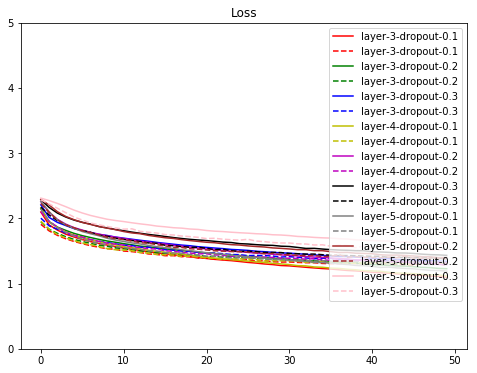

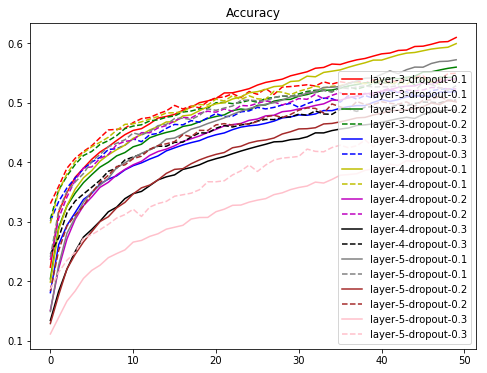

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k", "grey", "brown", "pink"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [9]:
results = {}
nn = [512, 256, 128, 64, 32]
dp = 0.2
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:], num_neurons=nn, drp_ratio=dp)
model.summary()
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
exp_name_tag = "layer-%s-dropout-%s" % (str(len(nn)), str(dp))
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0     

50000/50000 [==============================] - 8s 154us/sample - loss: 1.5623 - accuracy: 0.4415 - val_loss: 1.4939 - val_accuracy: 0.4802
Epoch 43/50
50000/50000 [==============================] - 8s 152us/sample - loss: 1.5595 - accuracy: 0.4439 - val_loss: 1.5025 - val_accuracy: 0.4666
Epoch 44/50
50000/50000 [==============================] - 7s 146us/sample - loss: 1.5625 - accuracy: 0.4429 - val_loss: 1.4868 - val_accuracy: 0.4764
Epoch 45/50
50000/50000 [==============================] - 8s 163us/sample - loss: 1.5539 - accuracy: 0.4439 - val_loss: 1.4916 - val_accuracy: 0.4690
Epoch 46/50
50000/50000 [==============================] - 8s 156us/sample - loss: 1.5543 - accuracy: 0.4456 - val_loss: 1.5104 - val_accuracy: 0.4668
Epoch 47/50
50000/50000 [==============================] - 8s 165us/sample - loss: 1.5522 - accuracy: 0.4440 - val_loss: 1.4763 - val_accuracy: 0.4791
Epoch 48/50
50000/50000 [==============================] - 8s 155us/sample - loss: 1.5468 - accuracy: 0.44

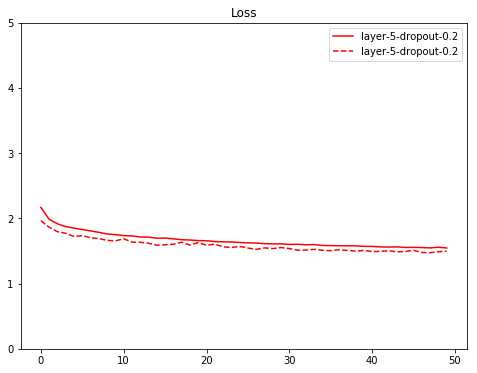

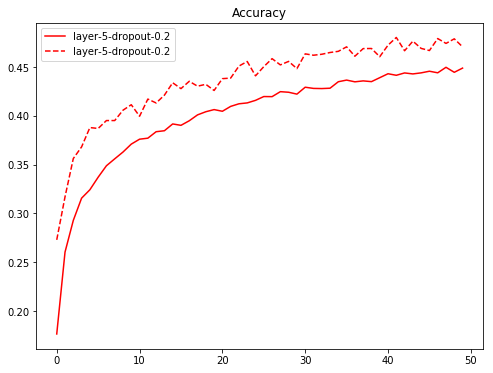

In [10]:
color_bar = ["r", "g", "b", "y", "m", "k", "grey", "brown", "pink"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()